**Import Data**


In [1]:
import pandas as pd
test=pd.read_csv('/content/fraudTest.csv')
test.head()

train=pd.read_csv('/content/fraudTrain.csv')
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


**Data Columns**

In [2]:
print(train.columns)
print(test.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def preprocess_datetime(df, datetime_column):
    df[datetime_column] = pd.to_datetime(df[datetime_column], errors='coerce')
    df.dropna(subset=[datetime_column], inplace=True)
    df['transaction_year'] = df[datetime_column].dt.year
    df['transaction_month'] = df[datetime_column].dt.month
    df['transaction_day'] = df[datetime_column].dt.day
    df['transaction_hour'] = df[datetime_column].dt.hour
    df['transaction_minute'] = df[datetime_column].dt.minute
    df['transaction_second'] = df[datetime_column].dt.second
    df.drop(columns=[datetime_column], inplace=True)
    return df

train = preprocess_datetime(train, 'trans_date_trans_time')
test = preprocess_datetime(test, 'trans_date_trans_time')

In [4]:
from sklearn.model_selection import train_test_split

target = 'is_fraud'
X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

# Handle missing values in the target variable
y_train = y_train.fillna(y_train.mode()[0])
y_test = y_test.fillna(y_test.mode()[0])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# Preprocessing pipeline

numeric_f = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
categorical_f = ['merchant', 'category', 'gender', 'state', 'job']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can choose a strategy here
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)
    ])
print(X_train.columns)

Index(['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'transaction_year', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_minute', 'transaction_second'],
      dtype='object')


**Displaying all Models**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define your models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

**Functions of all model graphs**


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [8]:
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
def plot_precision_recall_curve(precision, recall, title):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.show()

**Iteration**

In [10]:
# Iterate over models
for model_name, model in models.items():
    pl = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pl.fit(X_train, y_train)

    y_pred = pl.predict(X_test)
    y_prob = pl.predict_proba(X_test)[:, 1] if hasattr(pl, 'predict_proba') else None

    # Print classification report and confusion matrix
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    a_s=accuracy_score(y_test, y_pred)
    print("Accuracy:", a_s)
    print("\n")

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     27119
         1.0       0.00      1.00      0.01       116

    accuracy                           0.00     27235
   macro avg       0.50      0.50      0.00     27235
weighted avg       1.00      0.00      0.00     27235

Confusion Matrix:
 [[    1 27118]
 [    0   116]]
Accuracy: 0.0042959427207637235


Model: Random Forest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27119
         1.0       0.00      0.00      0.00       116

    accuracy                           1.00     27235
   macro avg       0.50      0.50      0.50     27235
weighted avg       0.99      1.00      0.99     27235

Confusion Matrix:
 [[27106    13]
 [  116     0]]
Accuracy: 0.9952634477694143


Model: Support Vector Machine
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Bar graph of Confusion matrix of SVM**

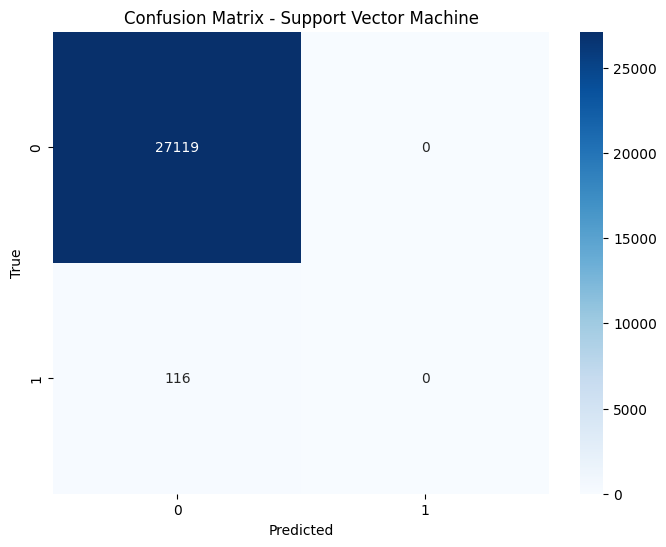

In [11]:
# Plot confusion matrix
plot_confusion_matrix(cm, model_name)

Graphs of SVM (ROC curves, Precision-Recall curve)

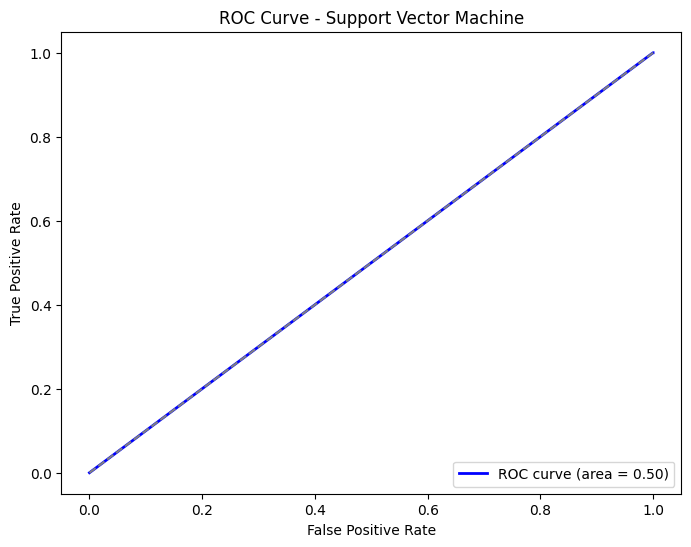

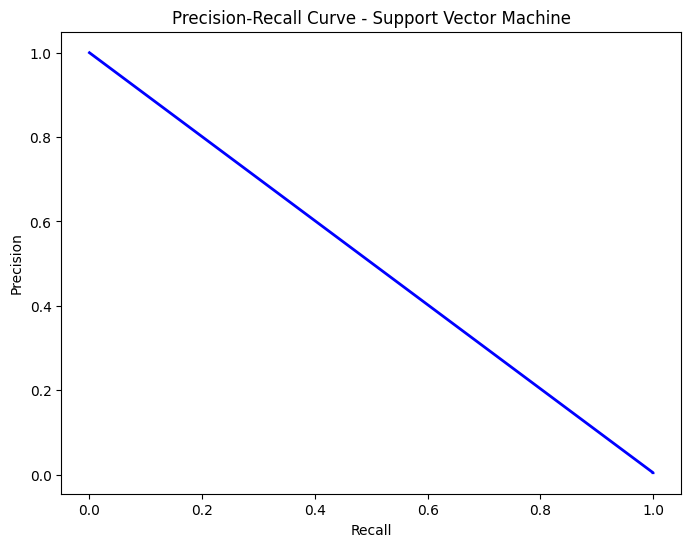

In [12]:
if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, model_name)

    # Plot Precision-Recall curve
if y_prob is not None:
        precision, recall, _ = precision_recall_curvRRRe(y_test, y_prob)
        plot_precision_recall_curve(precision, recall, model_name)

    # Feature Importance for tree-based models
if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'feature': numeric_f + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_f)),
            'importance': model.feature_importances_
        })
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
        plt.title(f'Top 10 Feature Importances - {model_name}')
        plt.show()